In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path

import precision_functions as prefun

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

### Constants

In [ ]:
EVENT = "rastoc:stillness-position-lost"

TRIAL_TAG = 'validation-stimulus' #Opcion: "fixation-stimulus"  # Es el momento donde aparece la cruz de fijacion
FIRST_SAMPLE = 300
MAX_PLOTS = 2
VERBOSE = True

ALL_FILES = list(Path("./raw_data").glob("*.csv"))
LOAD_PATH = "raw_data/gus_webcam4_computer_3_firefox_ubuntu.csv"

### Data load

In [4]:
print(LOAD_PATH)
df = pd.read_csv(LOAD_PATH)
df.head(5)

raw_data/gus_webcam4_computer_3_firefox_ubuntu.csv


,rt,response,trial_type,trial_index,time_elapsed,internal_node_id,run_id,condition,recorded_at,source_code_version,ip,user_agent,device,browser,browser_version,platform,platform_version,load_time,success,jspsych_start_time,item_width_mm,item_height_mm,item_width_px,px2mm,view_dist_mm,item_width_deg,px2deg,win_width_deg,win_height_deg,stimulus,response_type,key_press,avg_frame_time,center_x,center_y,rastoc-type,stimulus-coordinate,calibration-id,calibration-point-id,inner-width,inner-height,webgazer_data,webgazer_targets,session-id,validation-id,tracked-trial-id,trial-tag,start-x,start-y,events
0,55619.0,"{""name-id"":""Gustavo"",""webcam-id"":""4"",""computer...",survey-html-form,0,55622,0.0-0.0,31,1,2023-01-25 20:52:27,8250564b3bfde663ef6456354891c013,157.92.27.254,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,NaN,Firefox,109.0,Ubuntu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,webgazer-init-camera,1,89051,0.0-1.0,31,1,2023-01-25 20:52:27,8250564b3bfde663ef6456354891c013,157.92.27.254,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,NaN,Firefox,109.0,Ubuntu,NaN,5543.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,fullscreen,2,94271,0.0-2.0,31,1,2023-01-25 20:52:27,8250564b3bfde663ef6456354891c013,157.92.27.254,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,NaN,Firefox,109.0,Ubuntu,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,events-tracking-start,3,94272,0.0-3.0,31,1,2023-01-25 20:52:27,8250564b3bfde663ef6456354891c013,157.92.27.254,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,NaN,Firefox,109.0,Ubuntu,NaN,NaN,NaN,2023-01-25T20:52:30.671Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,44381.0,NaN,virtual-chinrest,4,138654,0.0-4.0,31,1,2023-01-25 20:52:27,8250564b3bfde663ef6456354891c013,157.92.27.254,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,NaN,Firefox,109.0,Ubuntu,NaN,NaN,NaN,NaN,85.6,53.98,344.0,4.02,582.52,8.404384,40.93102,46.908189,26.385856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check rastoc events

In [14]:
prefun.get_rastoc_events(df, EVENT)

[]

### Precision experiment analysis

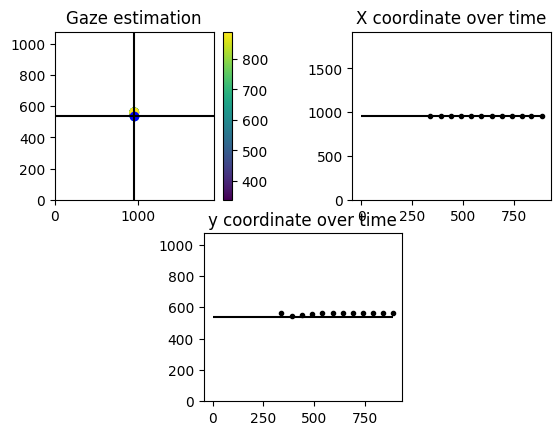

Horizontal error (pxs) = 0 +- 0 
Vertical error (pxs) = 23 +- 5 
Total error (pxs) = 23 +- 5 
Validation point (1): 960, 536
Time between samples (ms) = 50 +- 2 
Sampling rate (Hz) = 20 +- 1 
Range Sampling rate (Hz) = [19 21]
Last time sample = 889
k: 0


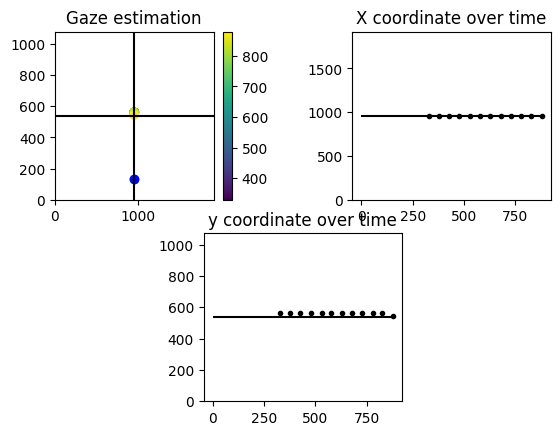

Horizontal error (pxs) = 0 +- 0 
Vertical error (pxs) = 429 +- 5 
Total error (pxs) = 429 +- 5 
Validation point (1): 960, 131
Time between samples (ms) = 50 +- 2 
Sampling rate (Hz) = 20 +- 1 
Range Sampling rate (Hz) = [19 22]
Last time sample = 879
k: 1
Error: 225.75 +- 286.85


In [5]:
df_res = prefun.calculate_and_plot_errors(df, 
                                   TRIAL_TAG,
                                   first_sample=FIRST_SAMPLE,
                                   max_plots=MAX_PLOTS, 
                                   verbose=VERBOSE)

print(f"Error: {df_res['total_errors_pxs_mean'].mean():.2f} +- {df_res['total_errors_pxs_mean'].std():.2f}")

In [ ]:
SAVE_PATH = f"analyzed/analyzed_{LOAD_PATH.split('/')[-1]}"
print(f'Saved: {SAVE_PATH}')
df_res.to_csv(SAVE_PATH, index=False)

<AxesSubplot: ylabel='Frequency'>

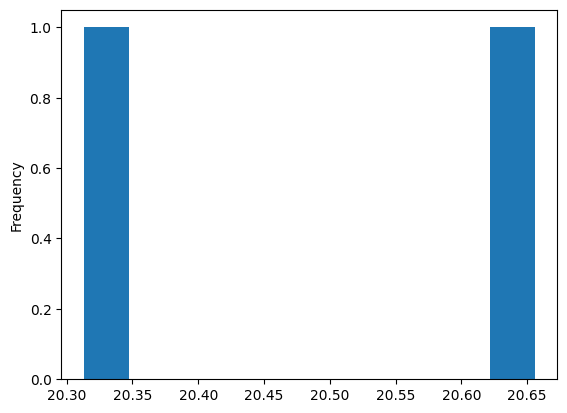

In [6]:
df_res["sampling_rate_mean"].plot(kind="hist")


In [7]:
print(f"Error: {df_res['total_errors_pxs_mean'].mean():.2f} +- {df_res['total_errors_pxs_mean'].std():.2f}")

Error: 225.75 +- 286.85


In [12]:


ALL_FILES = list(Path("./analyzed").glob("*.csv"))

prefun.evaluate_experiment_instances(ALL_FILES)

analyzed/analyzed_precision-experiment-2023-01-25T18_07_00.813Z.csv
Error: 184.40 +- 90.31
Sampling rate: 23.57 +- 7.06
---
analyzed/analyzed_firefox_cortito2.csv
Error: 163.32 +- 67.60
Sampling rate: 23.33 +- 6.16
---
analyzed/analyzed_precision-experiment-2023-01-24T17_15_59.068Z.csv
Error: 216.42 +- 100.02
Sampling rate: 23.74 +- 7.01
---
analyzed/analyzed_opera_cortito1.csv
Error: 208.05 +- 94.15
Sampling rate: 24.04 +- 12.12
---
